# Analysis of Interval Schwinger Spectrum

## By Rachel Houtz and James Ingoldby

## Date: 25th July, 2025

In [1]:
import os
import time
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import eigsh

In [2]:
# Import saved matrices and basis objects

# Replace with the filename you want
filename = os.path.join("Hams", "Emax15.npz")

# Load the .npz file
with np.load(filename, allow_pickle=True) as data:
    # Load basis
    basis = data['basis'].tolist()  # Convert back to Python list

    # Reconstruct H0
    H0 = csr_matrix((data['H0_data'], data['H0_indices'], data['H0_indptr']),
                    shape=tuple(data['H0_shape']))

    # Reconstruct lower triangular part of V
    Vlow = csr_matrix((data['V_data'], data['V_indices'], data['V_indptr']),
                   shape=tuple(data['V_shape']))
    
    # Reconstruct the full interaction
    V = Vlow + Vlow.T

# Now H0 and V are usable sparse matrices, and basis is a standard Python list
print(f"Loaded basis with {len(basis.stateList)} states")
print(f"H0 shape: {H0.shape}, nnz: {H0.nnz}")
print(f"V shape: {V.shape}, nnz: {V.nnz}")

Loaded basis with 146785 states
H0 shape: (146785, 146785), nnz: 146784
V shape: (146785, 146785), nnz: 34452920


In [3]:
# Compute the spectrum and check it looks reasonable
L = basis.L
g = 2.

H = H0 + (g**2*L/2) * V

which = 'SA'
k = 10
print("Computing Spectrum:")
start = time.time()
spectrum = eigsh(H, k=k, which=which, return_eigenvectors=False)
ex_time = time.time() - start
print(f"Time taken is: {ex_time}")

# Output gaps
ordered = np.sort(spectrum)
gaps = ordered - ordered[0]
print("Lowest gaps:")
print(gaps)

Computing Spectrum:
Time taken is: 29.48385214805603
Lowest gaps:
[0.         1.19517004 1.37514372 1.63193833 1.93469011 2.26562448
 2.39010096 2.57041994 2.61343704 2.75038991]


## Extracting Submatrices

In [4]:
energies = H0.diagonal()
# Define functions to pull out from H0 and V the elements between low energy states
def extract_submatrix(H, Emax):
    """Extracts the submatrix of H with eigenvalues less than Emax."""
    indices = np.where(energies < Emax)[0]
    return H[indices][:, indices]

In [5]:
# Test by extracting a submatrix and comparing its low energy spectrum with Mathematica
Emax_test = 8.0
H0_sub = extract_submatrix(H0, Emax_test)
V_sub = extract_submatrix(V, Emax_test)

H_sub = H0_sub + (g**2*L/2) * V_sub
spectrum_sub = eigsh(H_sub, k=k, which=which, return_eigenvectors=False)
gaps_sub = np.sort(spectrum_sub) - np.sort(spectrum_sub)[0]
print(f"Submatrix gaps for Emax={Emax_test}:")
print(gaps_sub)

Submatrix gaps for Emax=8.0:
[0.         1.19876896 1.37800958 1.63774053 1.94021031 2.27608751
 2.39675211 2.58038845 2.62415041 2.75936033]


## Plot Spectrum versus Emax

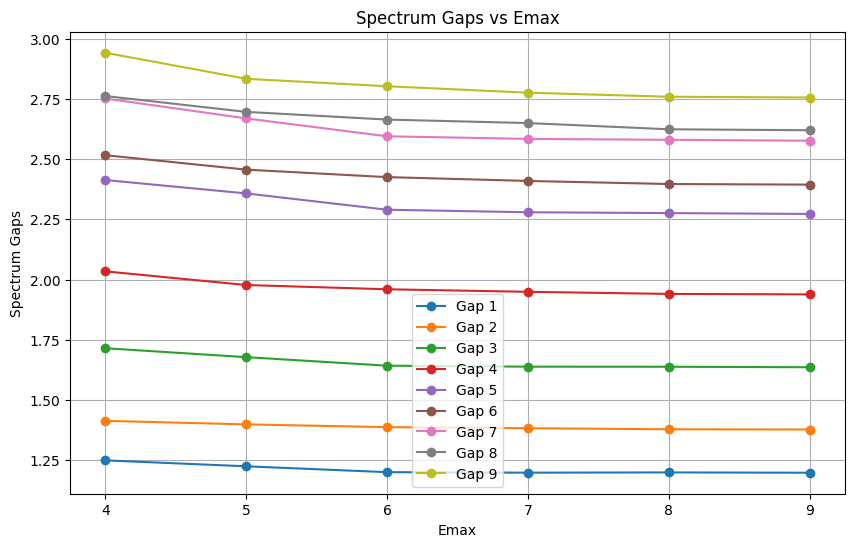

In [6]:
g = 2.
emax_list = range(4, 10)
spec_array = np.zeros((len(emax_list), k))
for i, Emax in enumerate(emax_list):
    H0_sub = extract_submatrix(H0, Emax)
    V_sub = extract_submatrix(V, Emax)

    H_sub = H0_sub + (g**2*L/2) * V_sub
    spectrum_sub = eigsh(H_sub, k=k, which=which, return_eigenvectors=False)
    spec_array[i] = spectrum_sub[::-1]

# Plot the gaps versus Emax
#print("Plotting gaps versus Emax")
gaps_array = spec_array - spec_array[:, 0][:, np.newaxis]
gaps_array = gaps_array[:, 1:]  # Exclude the first column (zero gap)
#print(gaps_array)

# Plotting the gaps
plt.figure(figsize=(10, 6))
for i in range(gaps_array.shape[1]):
    plt.plot(emax_list, gaps_array[:, i], marker='o', label=f'Gap {i+1}')
plt.title('Spectrum Gaps vs Emax')
plt.xlabel('Emax')
plt.ylabel('Spectrum Gaps')
plt.xticks(emax_list)
plt.grid()
plt.legend()
plt.show()

In [7]:
# Compare with exact results from Bosonization

def omega(n, g, L):
    """Exact spectrum for the bosonized theory."""
    mschsq = g**2/np.pi  # Mass scale, adjust as needed
    return np.sqrt(np.pi**2 * n**2 / (L**2) + mschsq)

def generate_bosonic_spectrum(k, g, L, max_occupations=4, max_modes=4):
    """
    Brute-force: generate all bosonic Fock states up to some cutoff and return lowest k energies.
    """
    # Compute mode energies
    omegas = [omega(n, g, L) for n in range(1, max_modes + 1)]

    states = []
    # Generate occupation number vectors
    for occ in itertools.product(range(max_occupations + 1), repeat=max_modes):
        E = sum(n * e for n, e in zip(occ, omegas))
        states.append(E)

    # Sort and return first k unique energy levels
    unique_sorted = sorted(set(states))
    return np.array(unique_sorted[:k])

# Generate the bosonic spectrum
bosonic_spectrum = generate_bosonic_spectrum(k, g, L, max_occupations=4, max_modes=4)
print("Bosonic spectrum:")
print(bosonic_spectrum)


Bosonic spectrum:
[0.         1.19476027 1.37480538 1.63130398 1.93407359 2.38952055
 2.56956565 2.74961075 2.82606425 3.00610935]


The Schwinger mass is: 2.256758334191025
Bosonic spectrum at stronger coupling:
[2.29067037 2.38952055 2.54575555 2.74961075 2.99136631]


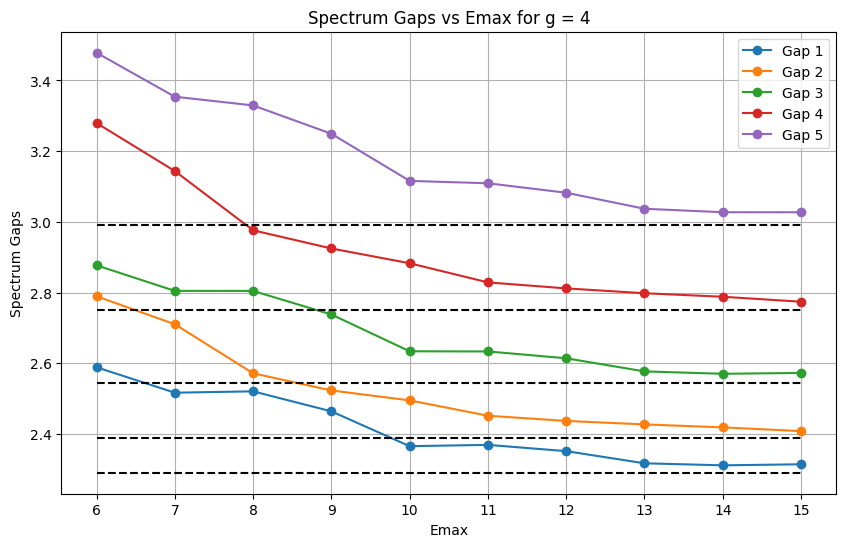

In [8]:
# Lets try to redraw the plot at stronger coupling with fewer gaps and compare with bosonisation

g = 4
schwinger_mass = np.sqrt(g**2/np.pi)  # Adjusted mass scale for stronger coupling
print("The Schwinger mass is:", schwinger_mass)

# Compute the exact bosonic spectrum for the new coupling
k = 6
bosonic_spectrum_strong = generate_bosonic_spectrum(k, g, L, max_occupations=4, max_modes=6)
print("Bosonic spectrum at stronger coupling:")
bosonic_spectrum_strong = bosonic_spectrum_strong[1:]  # Exclude the zero mode
print(bosonic_spectrum_strong)

# Compute the spectrum for the new coupling
which = 'SA'
emax_list_strong = range(6, 16)
spec_array = np.zeros((len(emax_list_strong), k))
for i, Emax in enumerate(emax_list_strong):
    H0_sub = extract_submatrix(H0, Emax)
    V_sub = extract_submatrix(V, Emax)

    H_sub = H0_sub + (g**2*L/2) * V_sub
    spectrum_sub = eigsh(H_sub, k=k, which=which, return_eigenvectors=False)
    spec_array[i] = spectrum_sub[::-1]

# Plot the gaps versus Emax for stronger coupling
gaps_array = spec_array - spec_array[:, 0][:, np.newaxis]
gaps_array = gaps_array[:, 1:]  # Exclude the first column (zero gap)
#print(gaps_array)
#print(gaps_array.shape)

plt.figure(figsize=(10, 6))
for i in range(gaps_array.shape[1]):
    plt.plot(emax_list_strong, gaps_array[:, i], marker='o', label=f'Gap {i+1}')
plt.hlines(y=bosonic_spectrum_strong, xmin=6, xmax=15, linestyle='--', color='black')
plt.title(f'Spectrum Gaps vs Emax for g = {g}')
plt.xlabel('Emax')
plt.ylabel('Spectrum Gaps')
plt.xticks(emax_list_strong)
plt.grid()
plt.legend()
#plt.savefig(f'spectrum_gaps_g{g}.png')
plt.show()

In [9]:
print(gaps_array)
print(spec_array)

[[2.58890904 2.78965699 2.87723208 3.27968998 3.47840089]
 [2.51700056 2.71057016 2.80491552 3.1438762  3.35402298]
 [2.5208073  2.57189886 2.80485246 2.97629439 3.32935963]
 [2.46425739 2.52330788 2.73819876 2.92483827 3.24926245]
 [2.36570207 2.495294   2.63411865 2.88306922 3.11597734]
 [2.36944394 2.45182615 2.63360164 2.82893848 3.10920333]
 [2.35165521 2.43713104 2.61432499 2.81194182 3.08246095]
 [2.31732923 2.42730176 2.57719636 2.79825111 3.03714213]
 [2.31155858 2.41893712 2.57046035 2.78830205 3.0273242 ]
 [2.31454475 2.40832081 2.57283679 2.77426472 3.02728349]]
[[-3.74079742 -1.15188839 -0.95114043 -0.86356535 -0.46110745 -0.26239654]
 [-3.84637297 -1.32937241 -1.13580282 -1.04145746 -0.70249677 -0.49234999]
 [-3.98273962 -1.46193232 -1.41084076 -1.17788716 -1.00644523 -0.65337999]
 [-4.02686506 -1.56260767 -1.50355718 -1.28866629 -1.10202679 -0.7776026 ]
 [-4.062824   -1.69712192 -1.56753    -1.42870535 -1.17975478 -0.94684666]
 [-4.11131561 -1.74187167 -1.65948946 -1.477